<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Изменение-баланса-классов" data-toc-modified-id="Изменение-баланса-классов-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Изменение баланса классов</a></span><ul class="toc-item"><li><span><a href="#Изменение-весов-классов" data-toc-modified-id="Изменение-весов-классов-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Изменение весов классов</a></span></li><li><span><a href="#Ресемплирование-с-уменьшением-класса-0" data-toc-modified-id="Ресемплирование-с-уменьшением-класса-0-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Ресемплирование с уменьшением класса 0</a></span></li></ul></li><li><span><a href="#Вывод-по-шагу-1" data-toc-modified-id="Вывод-по-шагу-1-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Вывод по шагу 1</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Классификатор-LogisticRegression" data-toc-modified-id="Классификатор-LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Классификатор LogisticRegression</a></span></li><li><span><a href="#Классификатор-DecisionTreeClassifier" data-toc-modified-id="Классификатор-DecisionTreeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Классификатор DecisionTreeClassifier</a></span></li><li><span><a href="#Классификатор-CatBoostClassifier" data-toc-modified-id="Классификатор-CatBoostClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Классификатор CatBoostClassifier</a></span></li><li><span><a href="#Классификатор-SGDClassifier" data-toc-modified-id="Классификатор-SGDClassifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Классификатор SGDClassifier</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [10]:
import warnings
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import nltk

from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
from wordcloud import WordCloud

In [3]:
warnings.filterwarnings('ignore')

In [4]:
tqdm.pandas()

In [5]:
toxic_comments = pd.read_csv('datasets/toxic_comments.csv')
toxic_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [6]:
toxic_comments.sample(5)

,Unnamed: 0,text,toxic
30888,30928,WP:AIV \n\nHello\n\nThank you for your report ...,0
55413,55474,"""\nOkay, FSF is a small political group, but t...",0
99554,99650,"""\n\nI tried. I honestly did. My reports were ...",0
55646,55707,"""\n{| class=""""user-block""""\n|\nWARNING!!!\n\n\...",1
56397,56458,Art Nouveau or Art Deco? \n\nHere is Wikipedia...,0


In [7]:
toxic_comments = toxic_comments.drop('Unnamed: 0', axis=1)

In [8]:
display(toxic_comments['toxic'].value_counts())
class_ratio = toxic_comments['toxic'].value_counts()[0] / toxic_comments['toxic'].value_counts()[1]
class_ratio

0    143106
1     16186
Name: toxic, dtype: int64

8.841344371679229

Гистограмма поля `toxic`

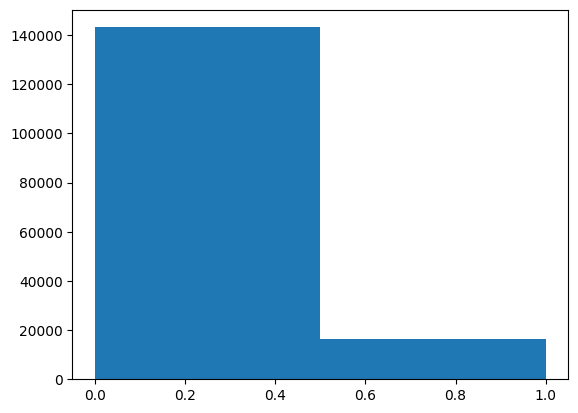

In [83]:
plt.hist(toxic_comments['toxic'], bins=2)
plt.show();

Классы несбалансированы. Отношение 1:8.84. Проведем поиск лучшего способа балансировки и сравним качество.

- Изменение весов в модели обучения
- Ресемплирование с уменьшением класса 0

Ресемплирование с увеличением класса 1 не будем использовать из-за громоздкого набора данных.

Подготовим признаки и целевой признак перед обучением.


In [9]:
%%time

nlp = spacy.load('en_core_web_sm')

def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Z] ', ' ', text.lower()).split())

def lemmatize(text):
    global nlp
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

toxic_comments['clear_text'] = toxic_comments['text'].progress_apply(clear_text)

toxic_comments['lemm_text'] = toxic_comments['clear_text'].progress_apply(lemmatize)


  0%|          | 0/159292 [00:00<?, ?it/s]

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: total: 19min 20s
Wall time: 21min 36s


Создадим облако слов поля `lemm_text`

In [11]:
text_raw = " ".join(toxic_comments['lemm_text'])
wordcloud = WordCloud().generate(text_raw)

In [15]:
def plot_cloud(wordcloud): 
    # Set figure size 
    plt.figure(figsize=(40, 30)) 
    # Display image 
    plt.imshow(wordcloud)  
    # No axis details 
    plt.axis("off")

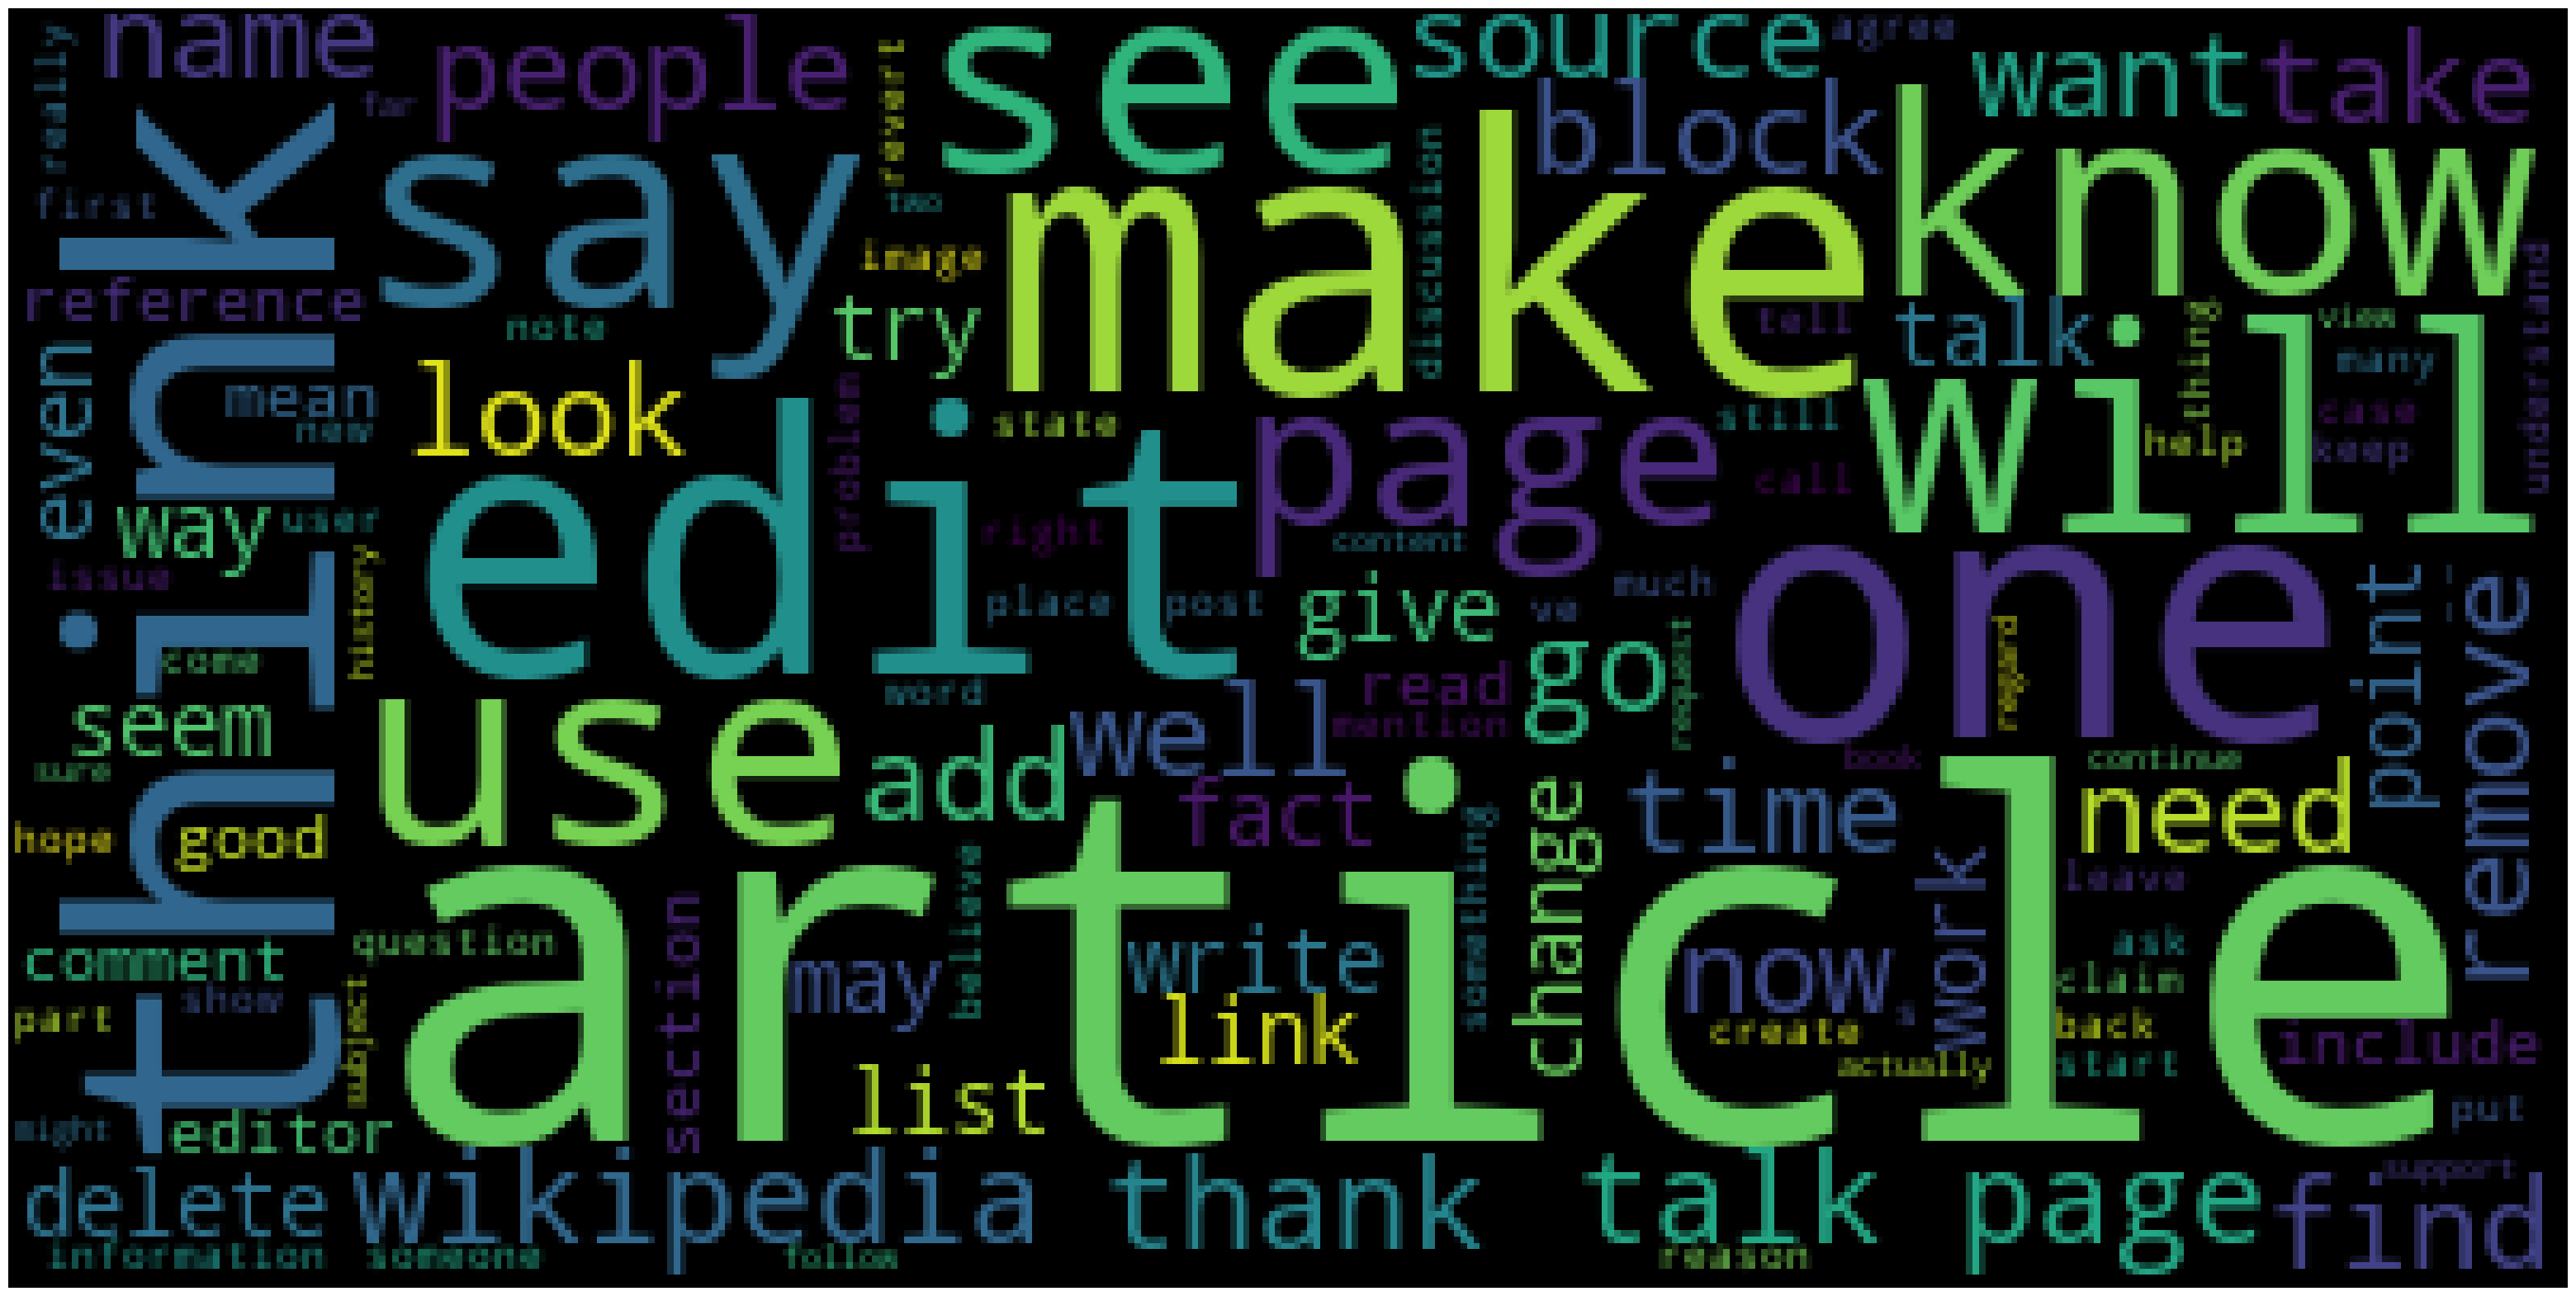

In [16]:
plot_cloud(wordcloud)

Разобьем выборку по отношению 60/20/20. Уменьшим количество кроссвалидаций до 3 из-за размера выборки.

In [37]:
target = toxic_comments['toxic']
features = toxic_comments.drop(['toxic'], axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state=12345,
                                                                              stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, 
                                                                            target_valid, 
                                                                            test_size=0.5,
                                                                            random_state=12345,
                                                                            stratify=target_valid)

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

count_tf_idf = TfidfVectorizer(stop_words=list(stopwords))

features_train = count_tf_idf.fit_transform(features_train['lemm_text'].values)
features_valid = count_tf_idf.transform(features_valid['lemm_text'].values)
features_test = count_tf_idf.transform(features_test['lemm_text'].values)
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
cv_counts = 3

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ilin_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(95575, 126051)
(31858, 126051)
(31859, 126051)


In [21]:
%%time

classificator = LogisticRegression(random_state=12345)
train_f1 = cross_val_score(classificator, 
                      features_train, 
                      target_train, 
                      cv=cv_counts, 
                      scoring='f1').mean()
print('F1 на CV', train_f1)

F1 на CV 0.6918081033849043
CPU times: total: 609 ms
Wall time: 4.74 s


### Изменение баланса классов

#### Изменение весов классов

In [26]:
%%time

dict_classes={0:1, 1:class_ratio}
classificator = LogisticRegression(class_weight=dict_classes)
train_f1_ballanced = cross_val_score(classificator, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_counts, 
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_ballanced)

F1 на CV с балансированными классами 0.7546316920332227
CPU times: total: 562 ms
Wall time: 5.82 s


In [27]:
%%time

classificator = LogisticRegression(class_weight='balanced')
train_f1_balanced = cross_val_score(classificator, 
                                    features_train, 
                                    target_train, 
                                    cv=cv_counts, 
                                    scoring='f1').mean()
print('F1 на CV с балансированными классами', train_f1_balanced)

F1 на CV с балансированными классами 0.7457810455328852
CPU times: total: 469 ms
Wall time: 4.14 s


Как видно на обучающей выборке F1-мера увеличилась.\
Ручная балансировка показала значение F1 чуть лучше встроенного, будем использовать его `class_weight=dict_classes`.

#### Ресемплирование с уменьшением класса 0

Сделаем количество записей с классом 0 таким же, как и количество записей с классом 1

In [38]:
toxic_comments_train = toxic_comments.iloc[target_train.index]

target_train_class_zero = toxic_comments_train[toxic_comments_train['toxic'] == 0]['toxic']
target_train_class_one = toxic_comments_train[toxic_comments_train['toxic'] == 1]['toxic']

In [39]:
target_train_class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
                                                                    random_state=12345)
target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

features_train_downsample = toxic_comments.iloc[target_train_downsample.index]
features_train_downsample, target_train_downsample = shuffle(features_train_downsample,
                                                             target_train_downsample,
                                                             random_state=12345)
features_train_downsample = count_tf_idf.transform(features_train_downsample['lemm_text']
                                                   .values)
del count_tf_idf
del stopwords

In [40]:
classificator = LogisticRegression(random_state=12345)
train_f1_downsampled = cross_val_score(classificator,
                      features_train_downsample, 
                      target_train_downsample, 
                      cv=cv_counts, 
                      scoring='f1').mean()
print('F1 на CV с уменьшением классов', train_f1_downsampled)

F1 на CV с уменьшением классов 0.8835845876770995


Прирост F1-меры ощутимый.

Построим ROC-AUC графики и просмотрим таблицу результатов баллансирования.

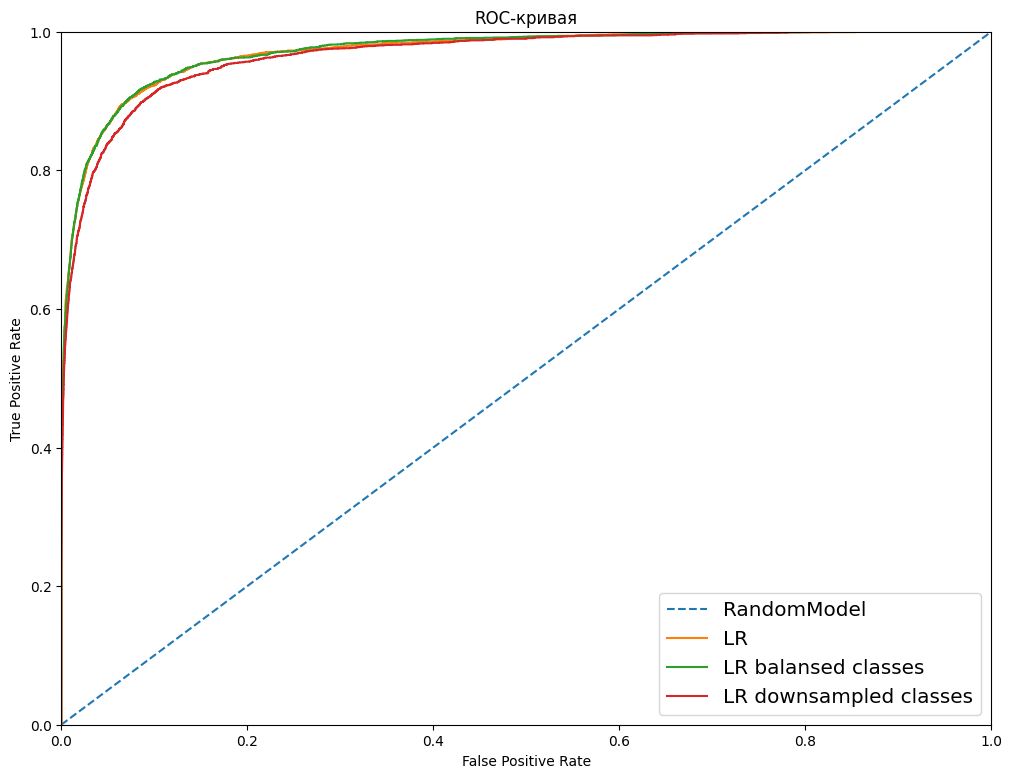

In [41]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression(random_state=12345)
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1 = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR')

classificator = LogisticRegression(random_state=12345, class_weight=dict_classes)
classificator.fit(features_train, target_train)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_balanced = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_balanced = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR balansed classes')

classificator = LogisticRegression(random_state=12345)
classificator.fit(features_train_downsample,target_train_downsample)
probabilities_valid = classificator.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_downsampled = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_downsampled = f1_score(target_valid, classificator.predict(features_valid))
plt.plot(fpr, tpr, label='LR downsampled classes')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

In [42]:
index = ['LogisticRegression',
         'LR balansed classes',
         'LR downsampled classes']
data = {'F1 на CV':[train_f1,
                    train_f1_balanced,
                    train_f1_downsampled],
        'F1 на валидации':[valid_f1,
                           valid_f1_balanced,
                           valid_f1_downsampled],
        'AUC-ROC':[auc_roc,
                   auc_roc_balanced,
                   auc_roc_downsampled]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,F1 на CV,F1 на валидации,AUC-ROC
LogisticRegression,0.691808,0.735675,0.971180
LR balansed classes,0.745781,0.763143,0.971925
LR downsampled classes,0.883585,0.704662,0.965962


Выберем метод балансировки по весу. Удалим ненужные переменные.

In [43]:
del toxic_comments_train
del target_train_class_zero
del target_train_class_one
del target_train_class_zero_downsample
del target_train_downsample
del features_train_downsample

### Вывод по шагу 1

В ходе преподготовки были получены признаки для обучения и разделена выборка на обучающую, валидационную и тестовую.

На тестировании оптимальными показателями F1 и AUC-ROC обладает классификатор, где учтен вес классов. В обучении мы будем использовать именно этот метод балансирования.

## Обучение

Для обучения выберем следующие модели:

1. LogisticRegression
2. DecisionTreeClassifier
3. CatBoostClassifier
4. SGDClassifier



### Классификатор LogisticRegression

In [45]:
%%time

classificator = LogisticRegression(random_state=12345,class_weight=dict_classes)
hyperparams = [{'solver':['newton-cg', 'lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                }]


print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
LR_best_params = clf.best_params_
print(LR_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_LR = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'C': 10, 'solver': 'lbfgs'}

Grid scores on development set:

0.714247 for {'C': 0.1, 'solver': 'newton-cg'}
0.714278 for {'C': 0.1, 'solver': 'lbfgs'}
0.714241 for {'C': 0.1, 'solver': 'liblinear'}
0.754596 for {'C': 1, 'solver': 'newton-cg'}
0.754632 for {'C': 1, 'solver': 'lbfgs'}
0.754596 for {'C': 1, 'solver': 'liblinear'}
0.761222 for {'C': 10, 'solver': 'newton-cg'}
0.761292 for {'C': 10, 'solver': 'lbfgs'}
0.761198 for {'C': 10, 'solver': 'liblinear'}

CPU times: total: 5.39 s
Wall time: 32.6 s


In [63]:
%%time

target_predict = clf.best_estimator_.predict(features_valid)
valid_f1_LR = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_LR)
print('F1 на валидации', valid_f1_LR)

F1 на cv 0.761291813094466
F1 на валидации 0.7690066996795807
CPU times: total: 0 ns
Wall time: 15.6 ms


### Классификатор DecisionTreeClassifier

In [64]:
%%time

classificator = DecisionTreeClassifier(random_state=12345,class_weight=dict_classes)
hyperparams = [{'max_depth':[x for x in range(30,50,5)],
                }]

print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
DTC_best_params = clf.best_params_
print(DTC_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_DTC = max(means)



# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'max_depth': 40}

Grid scores on development set:

0.642258 for {'max_depth': 30}
0.648963 for {'max_depth': 35}
0.658344 for {'max_depth': 40}
0.650984 for {'max_depth': 45}

CPU times: total: 5min 2s
Wall time: 5min 12s


In [65]:
%%time

target_predict = clf.best_estimator_.predict(features_valid)
valid_f1_DTC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_DTC)
print('F1 на валидации', valid_f1_DTC)

F1 на cv 0.6583437856219433
F1 на валидации 0.653331182448782
CPU times: total: 15.6 ms
Wall time: 15 ms


### Классификатор CatBoostClassifier

In [66]:
%%time

classificator = CatBoostClassifier(verbose=False, iterations=200)
classificator.fit(features_train, target_train)
target_predict = classificator.predict(features_valid)
cv_f1_CBC = cross_val_score(classificator,
                                         features_train, 
                                         target_train, 
                                         cv=cv_counts, 
                                         scoring='f1').mean()
valid_f1_CBC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_CBC)
print('F1 на валидации', valid_f1_CBC)

F1 на cv 0.7338608266387979
F1 на валидации 0.7514430014430016
CPU times: total: 26min 59s
Wall time: 5min 4s


### Классификатор SGDClassifier

In [67]:
%%time

classificator = SGDClassifier(random_state=12345,class_weight=dict_classes)
hyperparams = [{'loss':['hinge', 'log', 'modified_huber'],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
                }]

print('# Tuning hyper-parameters for f1_score')
print()
clf = GridSearchCV(classificator, hyperparams, scoring='f1',cv=cv_counts)
clf.fit(features_train, target_train)
print("Best parameters set found on development set:")
print()
SGDC_best_params = clf.best_params_
print(SGDC_best_params)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_SGDC = max(means)

# Tuning hyper-parameters for f1_score

Best parameters set found on development set:

{'eta0': 0.5, 'learning_rate': 'adaptive', 'loss': 'modified_huber'}

Grid scores on development set:

0.740460 for {'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'hinge'}
0.718667 for {'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'log'}
0.754668 for {'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'modified_huber'}
0.745002 for {'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge'}
0.721922 for {'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'log'}
0.756574 for {'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'modified_huber'}
0.671433 for {'eta0': 0.01, 'learning_rate': 'invscaling', 'loss': 'hinge'}
0.656510 for {'eta0': 0.01, 'learning_rate': 'invscaling', 'loss': 'log'}
0.660826 for {'eta0': 0.01, 'learning_rate': 'invscaling', 'loss': 'modified_huber'}
0.745613 for {'eta0': 0.01, 'learning_rate': 'adaptive', 'loss': 'hinge'}
0.720521 for {'eta0': 0.01, 'learning_rate': '

In [68]:
%%time

target_predict = clf.best_estimator_.predict(features_valid)
valid_f1_SGDC = f1_score(target_valid, target_predict)
print('F1 на cv', cv_f1_SGDC)
print('F1 на валидации', valid_f1_SGDC)

F1 на cv 0.7598061968533427
F1 на валидации 0.7642163661581137
CPU times: total: 0 ns
Wall time: 0 ns


Выведем таблицу валидации лучших моделей.

In [69]:
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'CatBoostClassifier',
         'SGDClassifier']
data = {'F1 на CV':[cv_f1_LR,
                    cv_f1_DTC,
                    cv_f1_CBC,
                    cv_f1_SGDC],
        'F1 на валидации':[valid_f1_LR,
                           valid_f1_DTC,
                           valid_f1_CBC,
                           valid_f1_SGDC]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Выполнение задачи'] = scores_data['F1 на валидации'] > 0.75
scores_data['Победитель'] = scores_data['F1 на валидации'] == scores_data['F1 на валидации'].max()
scores_data

,F1 на CV,F1 на валидации,Выполнение задачи,Победитель
LogisticRegression,0.761292,0.769007,True,True
DecisionTreeClassifier,0.658344,0.653331,False,False
CatBoostClassifier,0.733861,0.751443,True,False
SGDClassifier,0.759806,0.764216,True,False


На тестовых данных будем проверять LogisticRegression и SGDClassifier

Метрики LogisticRegression
ROC AUC: 0.9626378316866634
F1: 0.7584689837219534
Precision: 0.7219430485762144
Recall: 0.798887859128823
Accuracy: 0.9483034621300104

Метрики SGDClassifier
ROC AUC: 0.9672796905115884
F1: 0.7505211952744961
Precision: 0.6821627084386054
Recall: 0.8341056533827618
Accuracy: 0.9436579930317963



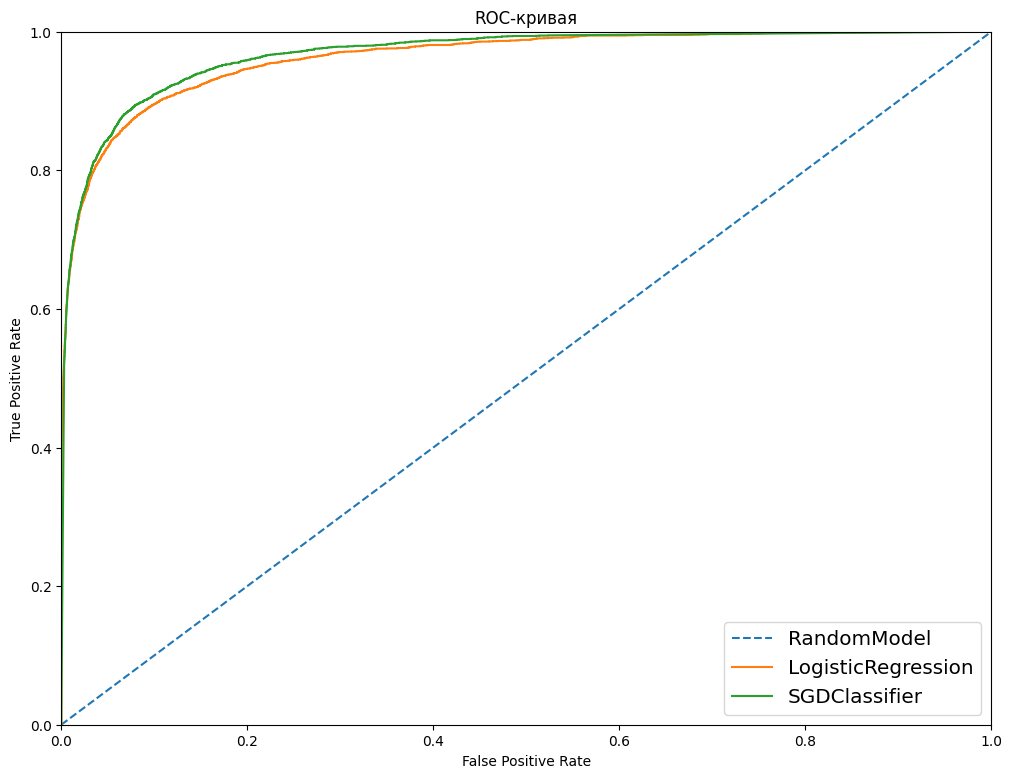

In [70]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


classificator = LogisticRegression(random_state=12345,class_weight=dict_classes)
classificator.set_params(**LR_best_params)
classificator.fit(features_train, target_train)
probabilities_test = classificator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = classificator.predict(features_test)
plt.plot(fpr, tpr, label='LogisticRegression')
print('Метрики LogisticRegression')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

classificator = SGDClassifier(random_state=12345,class_weight=dict_classes)
classificator.set_params(**SGDC_best_params)
classificator.fit(features_train, target_train)
probabilities_test = classificator.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = classificator.predict(features_test)
plt.plot(fpr, tpr, label='SGDClassifier')
print('Метрики SGDClassifier')
print('ROC AUC:', roc_auc_score(target_test, probabilities_one_test))
print('F1:', f1_score(target_test, predict_test))
print('Precision:', precision_score(target_test, predict_test))
print('Recall:', recall_score(target_test, predict_test))
print('Accuracy:', accuracy_score(target_test, predict_test))
print()

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title("ROC-кривая")
plt.show()

## Выводы

Итоговый вывод

В ходе работы над проектом было сделано:

- Подготовленны данные обучения на моделях.
- Выбран способ баланса классов и поделены данные на обучающую, валидационную и тестовою выборку.
- Обучены модели и выбраны лучшие из них на валидационной выборке.
- Показаны параметры качества моделей.

Исходные данные обладают большим количеством признаков. Созданных столбцов больше, чем записей данных. Так как TF-IDF превращают текст в численные значения, лучшими моделями стали LogisticRegression и SGDClassifier.

На тестовой выбоке по метрике F1 лучше всего себя показал LogisticRegression. Данная модель обладает большими показателями Precision и Accuracy. Это говорит нам, что токсичные комментарии находятся лучше.

SGDClassifier показал себя лучше в ROC AUC и Recall метриках. Модель способна обработать больше записей.